Accuracy: 0.5733830845771144
MSE: 20.6018
RMSE: 4.5389


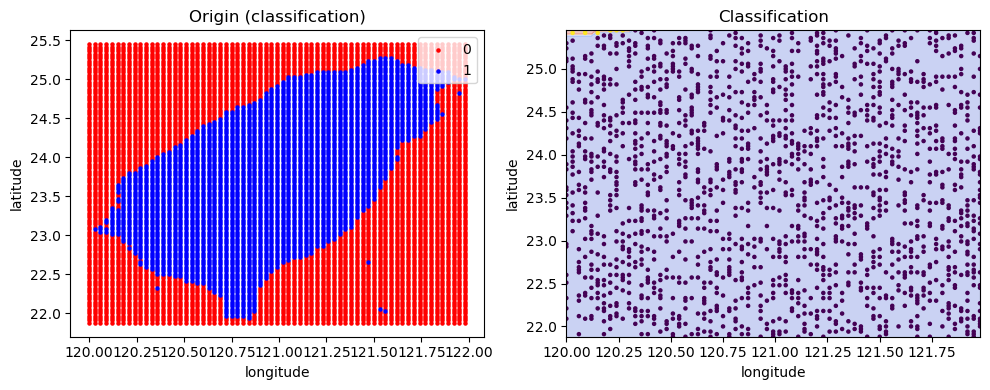

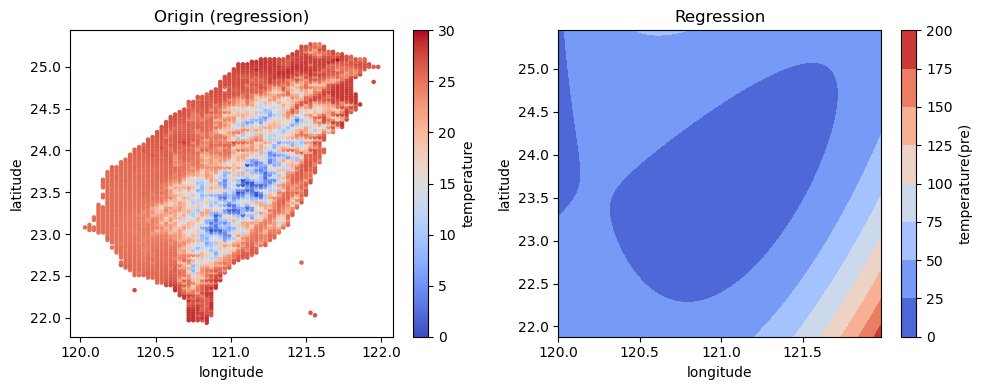

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import re
import math
import numpy as np

tree = ET.parse('O-A0038-003.xml')
root = tree.getroot()

# namespace
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

contents = root.findall('.//cwa:Content', ns)

data = []
pattern = re.compile(r'[-+]?\d+\.\d+E[+-]?\d+')  # 匹配像 -999.0E+00 28.1E+00

for c in contents:
    text = c.text
    numbers = pattern.findall(text)
    floats = [float(x) for x in numbers]
    data.extend(floats)

x = 120.00
y = 21.88

def Classification(data, x, y):
    A = []
    k = 0
    x0 = x
    for i in range(120):
        for j in range(67):
            if (data[k] == -999.0) :
                A = A + [[round(x, 2), round(y, 2), 0]]
            else :
                A = A + [[round(x, 2), round(y, 2), 1]]
            x = x + 0.03
            k = k + 1
        x = x0
        y = y + 0.03
    return A

def Regression(data, x, y):
    B = []
    k = 0
    x0 = x
    for i in range(120):
        for j in range(67):
            if (data[k] != -999.0E+00) :
                B = B + [[round(x, 2), round(y, 2), data[k]]]
            x = x + 0.03
            k = k + 1
        x = x0
        y = y +0.03
            
    return B
A = Classification(data, 120, 21.88)
#print("A=", A)

B = Regression(data, 120, 21.88)
#print("B=", B)


A = np.array(A)
X_class = A[:, :2]   # (經度, 緯度)
y_class = A[:, 2]    # 標籤 (0=無效, 1=有效)

# 分割資料
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# 訓練模型
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_c, y_train_c)

# 測試模型 
y_pred_c = clf.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)

print("Accuracy:", acc)

#
B = Regression(data, 120.00, 21.88)
B = np.array(B)

X_reg = B[:, :2] 
y_reg = B[:, 2] 

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0)

reg=make_pipeline(PolynomialFeatures(3),linear_model.LinearRegression())
reg.fit(X_train_r,y_train_r)

#reg = LinearRegression()
#reg.fit(X_train_r, y_train_r)

y_pred_r = reg.predict(X_test_r)
mse = mean_squared_error(y_test_r, y_pred_r) 
rmse = np.sqrt(mse)                    

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# --- 畫分類結果 ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_class[y_class==0,0], X_class[y_class==0,1], c='red', s=5, label='0')
plt.scatter(X_class[y_class==1,0], X_class[y_class==1,1], c='blue', s=5, label='1')
plt.title("Origin (classification)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend()

# 模型預測網格
lon_mesh = np.linspace(X_class[:,0].min(), X_class[:,0].max(), 100)
lat_mesh = np.linspace(X_class[:,1].min(), X_class[:,1].max(), 100)
Lon_mesh, Lat_mesh = np.meshgrid(lon_mesh, lat_mesh)
pred_class = clf.predict(np.c_[Lon_mesh.ravel(), Lat_mesh.ravel()]).reshape(Lon_mesh.shape)

plt.subplot(1,2,2)
plt.contourf(Lon_mesh, Lat_mesh, pred_class, cmap='coolwarm', alpha=0.3)
plt.scatter(X_test_c[:,0], X_test_c[:,1], c=y_pred_c, s=5)
plt.title("Classification")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.tight_layout()
plt.show()

# --- 畫迴歸結果 ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_reg[:,0], X_reg[:,1], c=y_reg, cmap='coolwarm', s=5, vmin=0, vmax=30)
plt.title("Origin (regression)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="temperature")

# 模型預測網格
pred_temp = reg.predict(np.c_[Lon_mesh.ravel(), Lat_mesh.ravel()]).reshape(Lon_mesh.shape)
plt.subplot(1,2,2)
plt.contourf(Lon_mesh, Lat_mesh, pred_temp, cmap='coolwarm')
plt.title("Regression")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="temperature(pre)")

plt.tight_layout()
plt.show()